# Modified by: Samuel Kollie


### Objectives

###### After completing this, you will be able to:

*   Extract, Transform, and Load Data

###### This notebook is part of my learning through Coursera IBM Data Science journey. Please reach out to me with any questions. Thank you!

### Table of Contents

*   Working Directory Acccess

*   Displaying Databricks ETL process flow Image

*   Import software libraries

*   Working with Pandas DataFrame 

*   Connecting to SQL

*   Read or SELECT data from SQL

# Working Directory Acccess


In [ ]:
# Checking or Accessing Current Working Directory

import os
os.getcwd()

In [ ]:
# Change or Set Current Working Directory

import os
# os.chdir('C:\Users\YOURUSERID\Downloads') - for windows, change \ to \\

os.chdir('C:\\Users\\YOURUSERID\\Downloads')

In [ ]:
# Comfirming Current Working Directory Access

import os
os.getcwd()

#   Displaying Databricks ETL process flow Image


In [ ]:
# ##### Inserting image from personal folder.

from IPython import display

display.Image("ETL.png")

# Source: Databricks

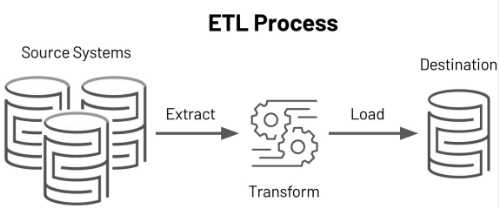

#   Import key software libraries


In [ ]:
import sys           # Read system parameters.
import pandas as pd  # Manipulate and analyze data.
import sqlite3       # Manage SQL databases.
import pyodbc        # accessing ODBC (Open Database Connectivity) databases.


# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- pandas {}'.format(pd.__version__))
print('- sqlite3 {}'.format(sqlite3.sqlite_version))

 #   Working with Pandas DataFrame 


In [ ]:
complaints_data = pd.read_csv('consumer_loan_complaints.csv')
complaints_data

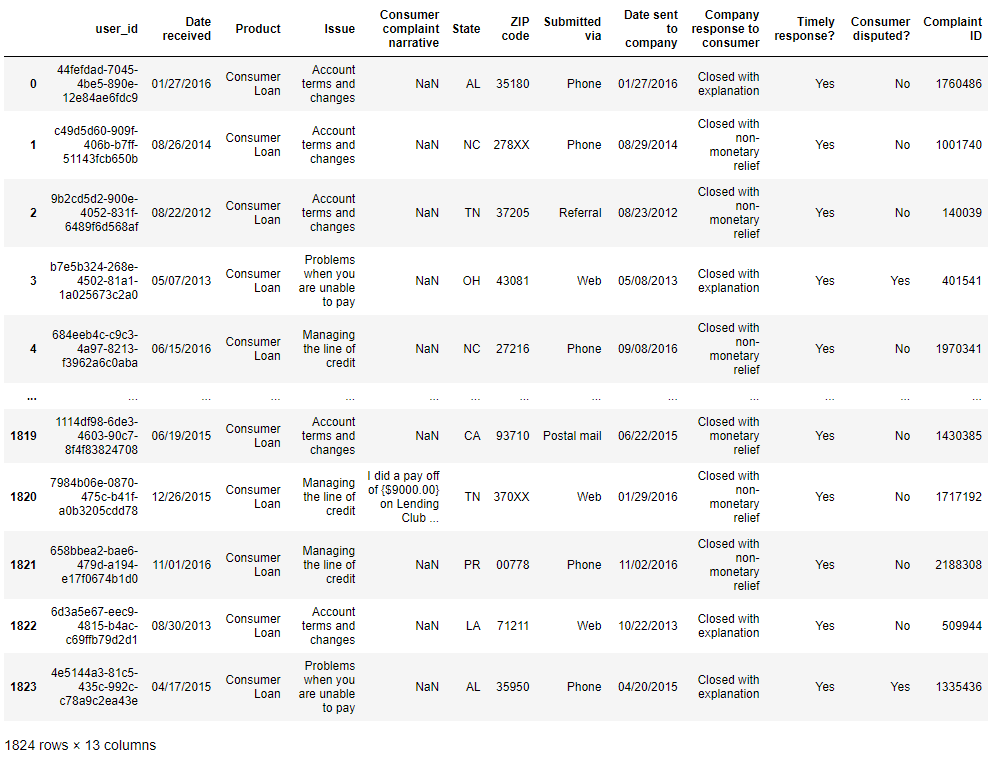

In [ ]:
complaints_data.head(n = 7)

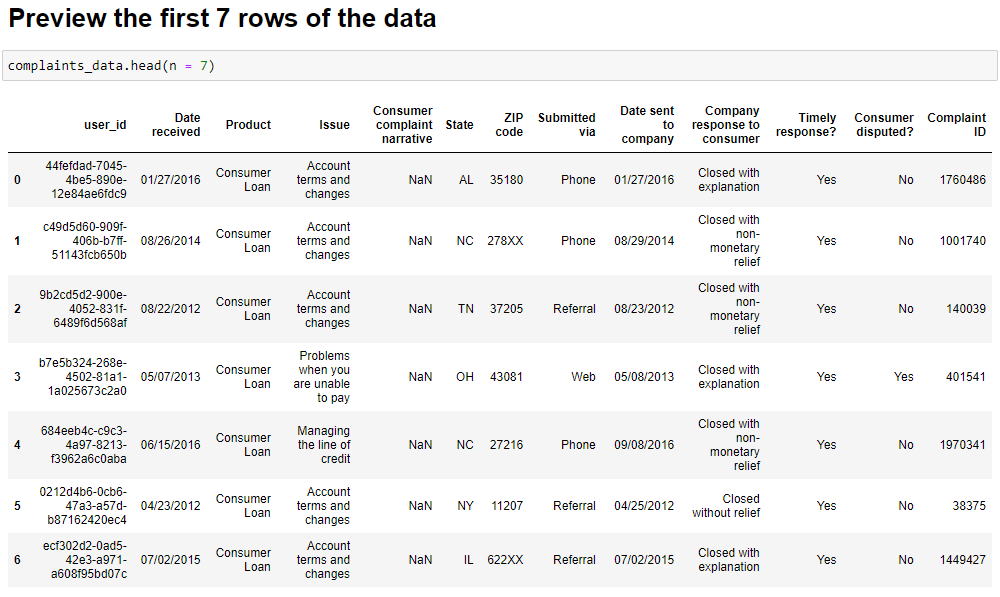

# Create a connection to the SQLite database

In [ ]:
conn = sqlite3.connect('/home/jovyan/work/ETL/data/user_data.db')
conn

# Create a connection to your own SQL database

*   Install pyodbc: run pip install pyodbc in terminal

In [ ]:
pip install pyodbc

In [ ]:
# Connect Python to SQL Server

import pyodbc 

# conn = pyodbc.connect('Driver={SQL Server};'
                      # 'Server=server_name;'
                      # 'Database=database_name;'
                      # 'Trusted_Connection=yes;')

# cursor = conn.cursor()
# cursor.execute('SELECT * FROM table_name')

# for i in cursor:
    # print(i)

# Read or SELECT data from SQL

In [ ]:
# Write a query that selects everything from the users table.

query = 'SELECT * FROM users'

In [ ]:
# Read the query into a Pandas DataFrame.

users = pd.read_sql(query, conn)

# Preview the data.

users.head()

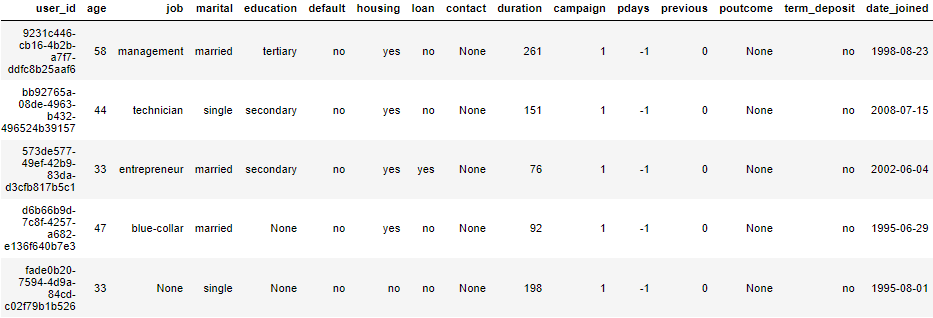

In [ ]:
query = 'SELECT * FROM device'

device = pd.read_sql(query, conn)

device.head()

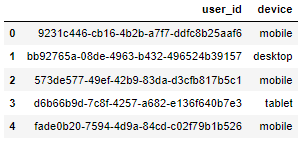

In [ ]:
# Read the user transactions in the last 30 days. 

query = 'SELECT * FROM transactions'

transactions = pd.read_sql(query, conn)

transactions.head()

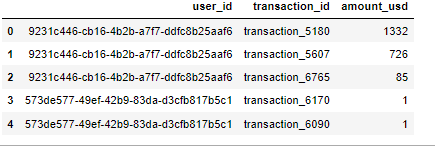

In [ ]:
# Aggregate data on the number of transactions and the total amount.

query = '''SELECT user_id, 
                  COUNT(*) AS number_transactions, 
                  SUM(amount_usd) AS total_amount_usd 
           FROM transactions 
           GROUP BY user_id'''

transactions_agg = pd.read_sql(query, conn)

transactions_agg.head()

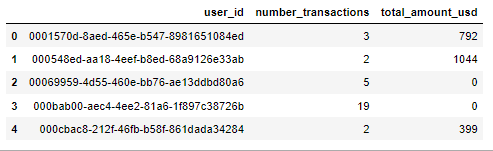

In [ ]:
# Do a left join, as all users in the users table are of interest.

query = '''SELECT left_table.*,           
                  right_table.device       
           FROM users AS left_table         
           LEFT JOIN device AS right_table   
             ON left_table.user_id = right_table.user_id'''

users_w_device = pd.read_sql(query, conn)

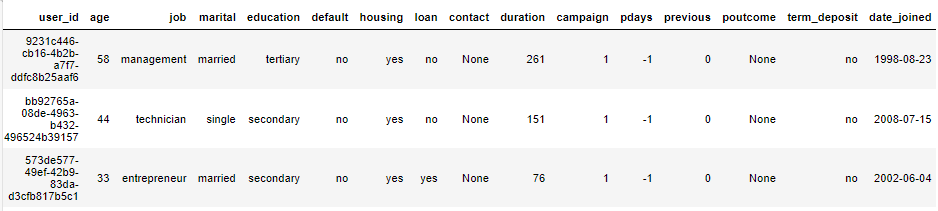

In [ ]:
users_w_device.shape

In [ ]:
# Close the database connection

conn.close()

In [ ]:
# Do a right join so users won't be lost.

users_w_devices_and_transactions = \
transactions_agg.merge(users_w_device,
                       on = 'user_id', how = 'right')

users_w_devices_and_transactions.head()

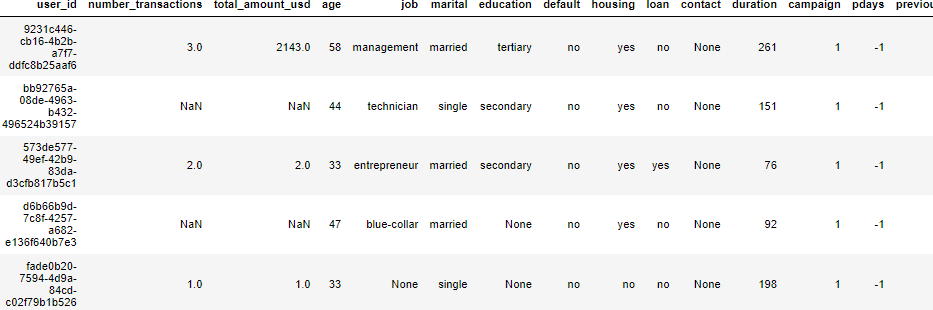

In [ ]:
# Make sure number of rows is equal to users_w_devices table.

users_w_devices_and_transactions.shape

In [ ]:
# Identify data where `age` is greater than 150

users_w_devices_and_transactions[users_w_devices_and_transactions.age > 150]

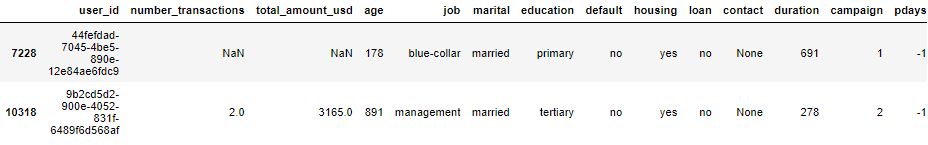

In [ ]:
# Drop incorrect data

users_cleaned = \
users_w_devices_and_transactions[users_w_devices_and_transactions.age < 150]

users_cleaned.shape

In [ ]:
# Identify more potentially erroneous data

# Compare age to device.

pd.crosstab(users_cleaned['age'], users_cleaned['device'])

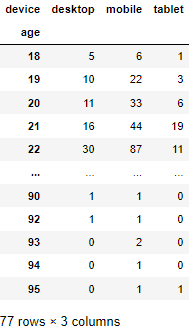

In [ ]:
# Identify data types that need correcting

users_cleaned.info()

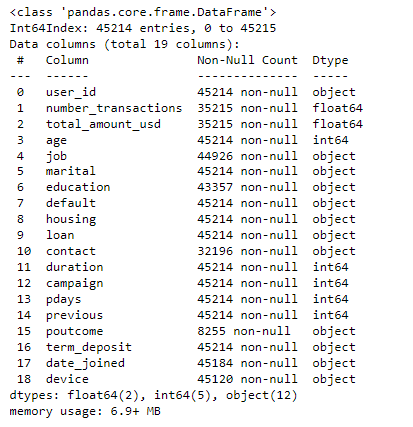

In [ ]:
users_cleaned.default.value_counts()

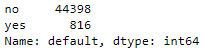

In [ ]:
# Convert the relevant variables to a Boolean type

users_cleaned_1 = users_cleaned.copy()  # Work with a new object.

users_cleaned_1.default = \
users_cleaned_1.default.map(dict(yes = 1, no = 0)).astype(bool)

users_cleaned_1.default.value_counts()

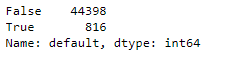

In [ ]:
# Do the same for the other Boolean variables.

bool_vars = ['housing', 'loan', 'term_deposit']

for var in bool_vars:
    users_cleaned_1[var] = \
    users_cleaned_1[var].map(dict(yes = 1, no = 0)).astype(bool)

    print(f'Converted {var} to Boolean.')

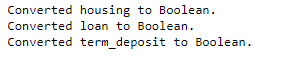

In [ ]:
users_cleaned_1.info()

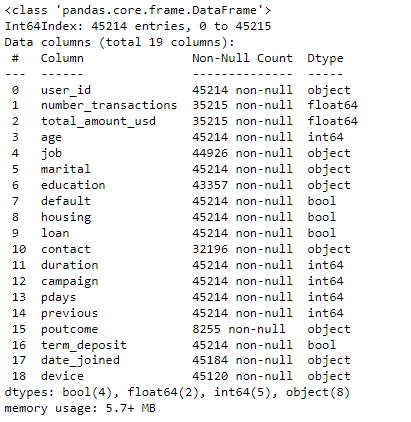

In [ ]:
# Convert `date_joined` to a datetime format

users_cleaned_2 = users_cleaned_1.copy()  # Work with a new object.

users_cleaned_2['date_joined'] = \
pd.to_datetime(users_cleaned_2['date_joined'],
               format = '%Y-%m-%d')

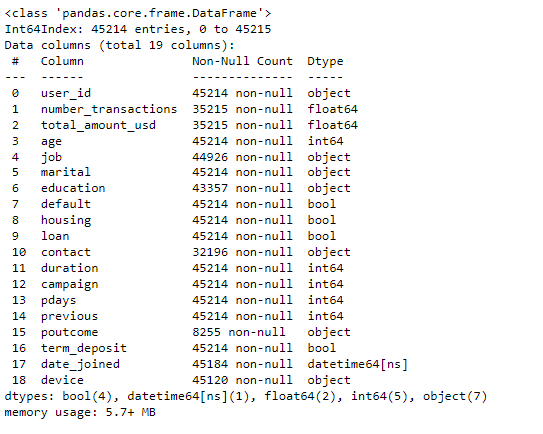

In [ ]:
# Identify all duplicated data

duplicated_data = \
users_cleaned_2[users_cleaned_2.duplicated(keep = False)]

print('Number of rows with duplicated data:',
      duplicated_data.shape[0])

In [ ]:
duplicated_data

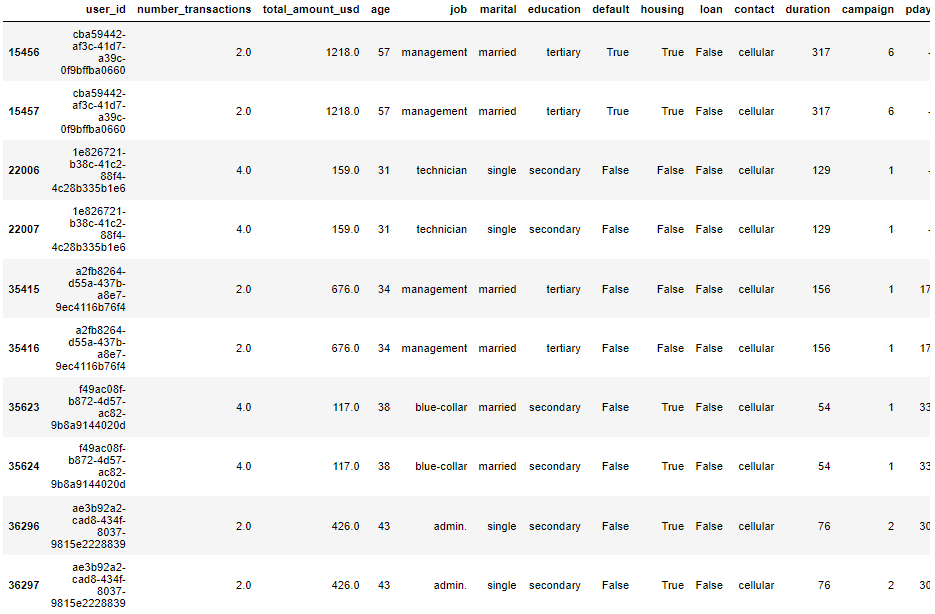

In [ ]:
# Remove the duplicated data

users_cleaned_final = \
users_cleaned_2[~users_cleaned_2.duplicated()]

users_cleaned_final[users_cleaned_final['user_id'] == \
'cba59442-af3c-41d7-a39c-0f9bffba0660']

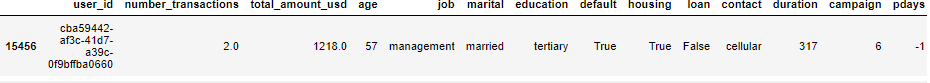

In [ ]:
# Load data into an SQL database

conn = sqlite3.connect('users_data_cleaned.db')

users_cleaned_final.to_sql('users_cleaned_final',
                           conn,
                           if_exists = 'replace',
                           index = False)

In [ ]:
# Confirm that data was loaded into the database

query = 'SELECT * FROM users_cleaned_final'

pd.read_sql(query, conn).head()

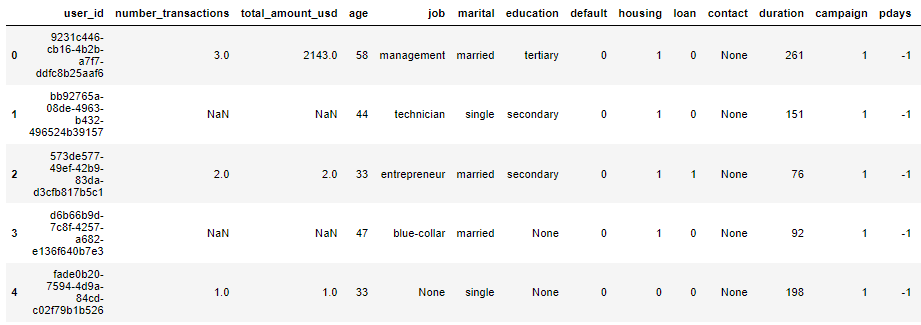

In [ ]:
# Close the database connection

users_cleaned_final.to_pickle('users_data_cleaned.pickle')

In [ ]:
# Confirm that the data was written to the pickle file

pd.read_pickle('users_data_cleaned.pickle').head()

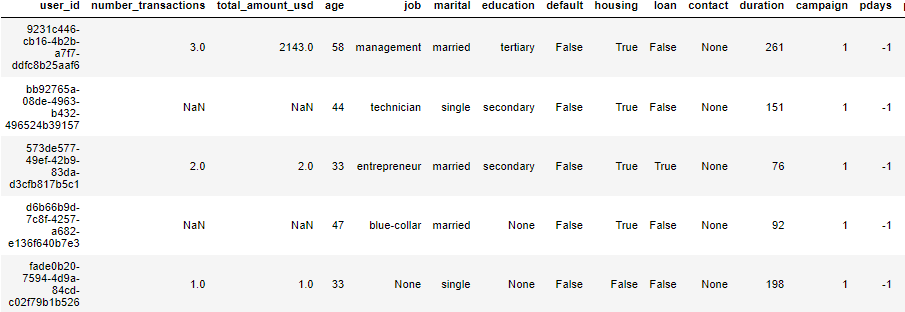

In [ ]:
pd.read_pickle('users_data_cleaned.pickle').info()

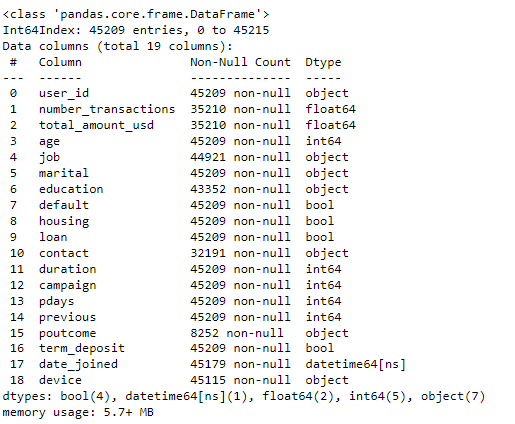

In [ ]:
# Confirm that the data was written to a CSV file.

pd.read_csv('users_data_cleaned.csv').head()

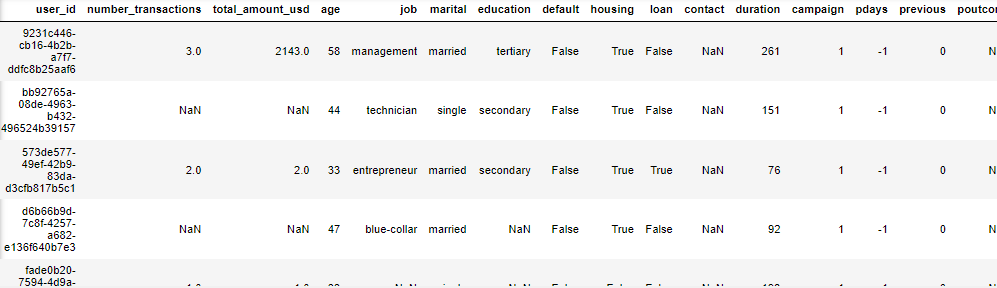

In [ ]:
pd.read_csv('users_data_cleaned.csv').info()

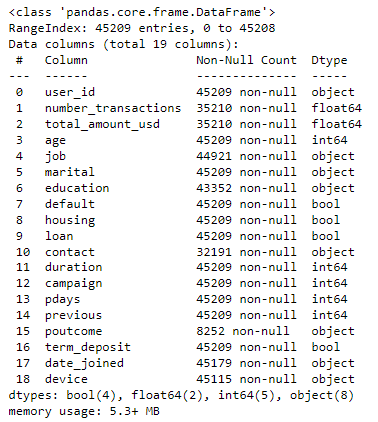